In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import json

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

params = json.loads(open('params.json', 'r').read())

# Date range
start = params["start_date"]
end = params["end_date"]

# Tickers of assets
OIL = 'Oil gas biofuels, exploration, refining etc'
TELCO = 'Telecommunications'
PULP_PAPER = 'Pulp and Paper'
ELECTRICAL = 'Electrical energy'
MINERALS = 'Minerals'

industry_asset = json.loads(open('stocks.json', 'r').read())
assets = []
for value in industry_asset[ELECTRICAL]:
    assets.append(value)

# Downloading data
data = yf.download(assets, start = start, end = end)

data = data.loc[:,('Adj Close', slice(None))]

data.columns = assets


[*********************100%%**********************]  9 of 9 completed


In [2]:
# Calculating returns
Y = data[assets].pct_change().dropna()

display(Y.tail())

,ENGI11.SA,GPAR3.SA,TAEE11.SA,ALUP11.SA,CPFE3.SA,CMIG3.SA,ELET3.SA,EQTL3.SA,EGIE3.SA
Date,,,,,,,,,
2023-10-27,-1.3291%,-2.4167%,-0.9177%,-1.0401%,-2.1925%,-1.5756%,-2.4152%,0.0000%,-1.0201%
2023-10-30,-0.4254%,1.5395%,-1.2549%,-1.5515%,0.0000%,-1.5582%,-2.0677%,0.0000%,-0.6184%
2023-10-31,-0.3204%,1.5161%,1.1800%,-0.1017%,1.4265%,1.0624%,1.0877%,0.0000%,0.1185%
2023-11-01,0.8214%,7.0130%,1.5251%,2.2646%,3.4443%,2.7033%,2.0886%,0.0000%,0.5919%
2023-11-03,1.5941%,2.1238%,1.7379%,1.6920%,2.3862%,1.1072%,2.0149%,11.1111%,2.1771%


,ENGI11.SA,GPAR3.SA,TAEE11.SA,ALUP11.SA,CPFE3.SA,CMIG3.SA,ELET3.SA,EQTL3.SA,EGIE3.SA
weights,4.3950%,35.6696%,0.0000%,0.0000%,0.0000%,0.0000%,8.0118%,12.9395%,38.9841%


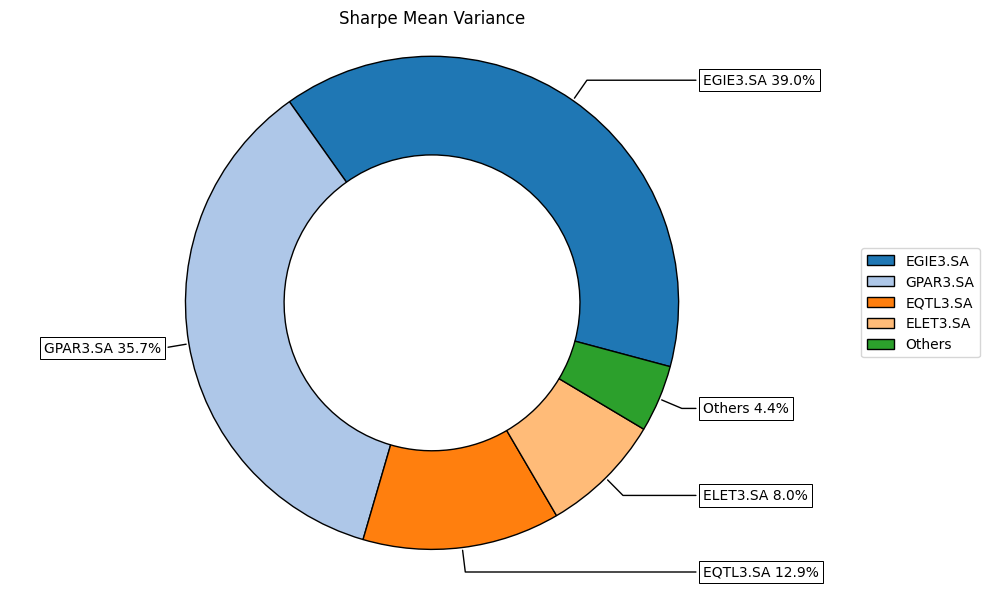

In [3]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_sharpe = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w_sharpe.T)

# Plotting the composition of the portfolio

ax_sharpe = rp.plot_pie(w=w_sharpe, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

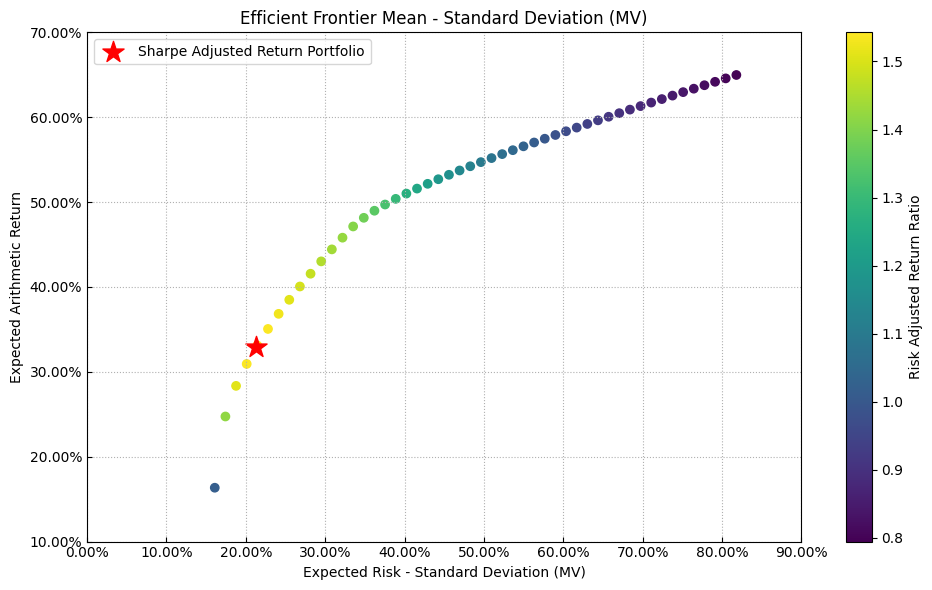

In [4]:
# Plotting frontier

points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
# display(frontier.T.tail())

# Plotting the efficient frontier

label = 'Sharpe Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w_sharpe, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)


In [5]:
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

In [6]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
ENGI11.SA,4.40%,0.93%,0.00%,0.00%,0.00%,0.31%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
GPAR3.SA,35.67%,6.93%,30.25%,0.00%,30.51%,32.81%,23.35%,17.35%,41.41%,40.93%,36.74%,41.30%,40.71%
TAEE11.SA,0.00%,0.68%,0.00%,0.00%,0.00%,1.74%,5.42%,11.97%,0.00%,5.56%,0.00%,0.80%,0.00%
ALUP11.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CPFE3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,7.03%,0.00%,0.00%,0.00%,0.00%
CMIG3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
ELET3.SA,8.01%,0.24%,8.24%,0.00%,8.98%,11.79%,30.61%,51.45%,1.14%,10.24%,9.84%,4.30%,7.76%
EQTL3.SA,12.94%,83.34%,27.19%,100.00%,25.85%,19.65%,13.83%,10.68%,8.66%,7.06%,12.58%,10.73%,10.13%
EGIE3.SA,38.98%,7.87%,34.31%,0.00%,34.66%,33.71%,26.79%,8.55%,41.76%,36.22%,40.84%,42.87%,41.39%


,ENGI11.SA,GPAR3.SA,TAEE11.SA,ALUP11.SA,CPFE3.SA,CMIG3.SA,ELET3.SA,EQTL3.SA,EGIE3.SA
weights,26.1606%,0.0000%,0.0000%,35.9286%,0.0000%,0.0000%,0.0000%,3.2409%,34.6699%


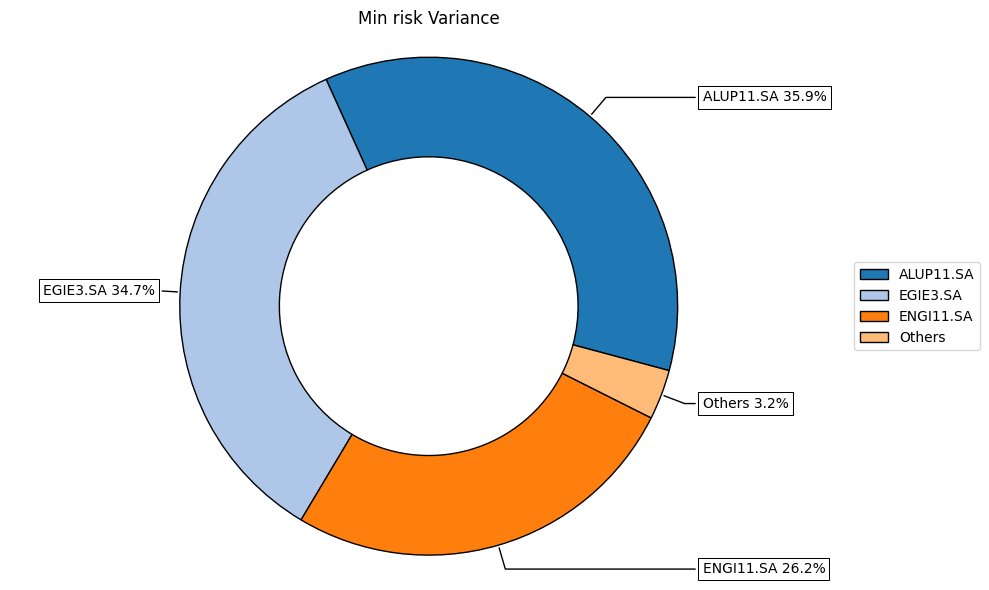

In [7]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_min_risk = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w_min_risk.T)


# Plotting the composition of the portfolio

ax_min_risk = rp.plot_pie(w=w_min_risk, title='Min risk Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

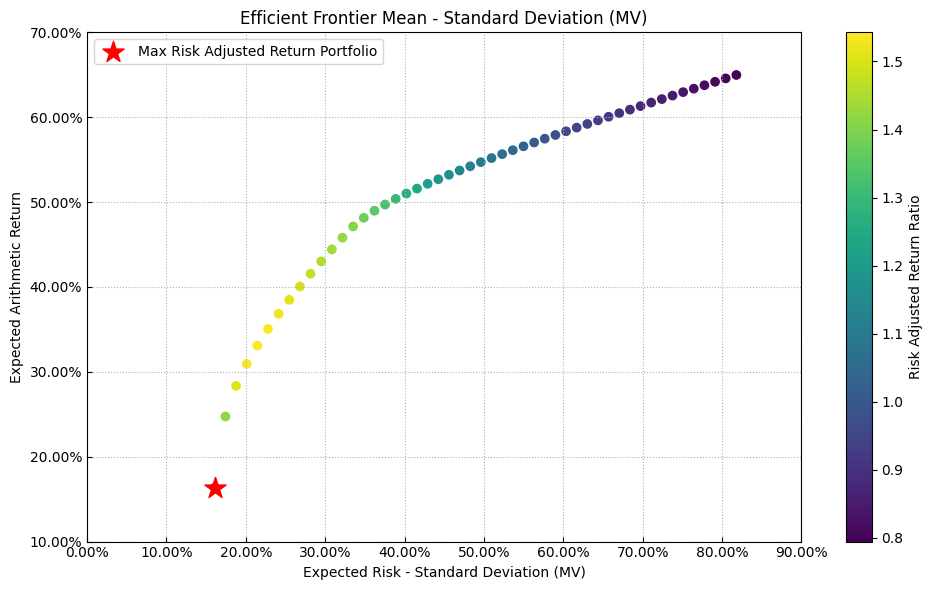

In [8]:
# Plotting frontier

points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
# display(frontier.T.tail())

# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w_min_risk, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)


In [9]:
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

In [10]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
ENGI11.SA,26.16%,16.12%,24.55%,18.05%,23.59%,29.30%,29.43%,27.66%,4.36%,6.41%,6.33%,10.04%,0.76%
GPAR3.SA,0.00%,0.00%,0.00%,1.31%,2.07%,2.60%,4.55%,0.00%,3.71%,9.96%,2.16%,10.95%,0.00%
TAEE11.SA,0.00%,0.00%,0.00%,0.19%,0.00%,0.00%,0.01%,0.00%,0.00%,4.46%,0.00%,2.43%,0.00%
ALUP11.SA,35.93%,34.73%,34.24%,29.26%,29.58%,26.72%,48.39%,50.76%,52.22%,40.37%,49.81%,41.43%,55.96%
CPFE3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,8.05%,0.00%,0.00%,0.00%,5.58%
CMIG3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.03%,13.59%,0.00%,0.00%,0.00%,0.00%,0.00%
ELET3.SA,0.00%,0.00%,0.28%,1.27%,1.66%,3.94%,9.03%,0.00%,2.53%,9.45%,13.97%,10.42%,7.92%
EQTL3.SA,3.24%,5.66%,5.63%,7.79%,7.40%,6.38%,6.29%,7.99%,5.82%,6.23%,5.04%,5.84%,6.21%
EGIE3.SA,34.67%,43.49%,35.29%,42.12%,35.70%,31.05%,2.27%,0.00%,23.32%,23.11%,22.69%,18.91%,23.56%
